# Model Training
In this section we will explore differnt models to train and predict the `total time` to complete the race by the driver at the middel of the race session.

In [2]:
""" Imports """
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import joblib
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

data_path = "../Dataset/final_df.xlsx"


## Loading and preparing Data

In [5]:
df = pd.read_excel(data_path)
df = df[df["year"]>2010] # choosing data from 2010 to get the relevant race formats for the current races
df.head()

,Unnamed: 0,raceId,driverId,lap,lap_position,lap_time,constructorId,number,quali_position,q1,...,no_of_stops,pit_stop_duration,result_position,total_laps,total_time,statusId,year,round,grand_prix_name,driverRef
0,0,841,20,1,1,98.109,9.0,1.0,1.0,85.296,...,NaN,NaN,1,58,5370.259,1,2011,1,Australian Grand Prix,vettel
1,1,841,20,2,1,93.006,9.0,1.0,1.0,85.296,...,NaN,NaN,1,58,5370.259,1,2011,1,Australian Grand Prix,vettel
2,2,841,20,3,1,92.713,9.0,1.0,1.0,85.296,...,NaN,NaN,1,58,5370.259,1,2011,1,Australian Grand Prix,vettel
3,3,841,20,4,1,92.803,9.0,1.0,1.0,85.296,...,NaN,NaN,1,58,5370.259,1,2011,1,Australian Grand Prix,vettel
4,4,841,20,5,1,92.342,9.0,1.0,1.0,85.296,...,NaN,NaN,1,58,5370.259,1,2011,1,Australian Grand Prix,vettel


### Data Dictionary

- **`raceId`**: Unique identifier for a specific race event.
- **`driverId`**: Unique identifier for a driver participating in the race.
- **`lap`**: Lap number within the race.
- **`lap_position`**: Position of the driver at the end of the current lap.
- **`lap_time`**: Time taken by the driver to complete the lap (in seconds).
- **`constructorId`**: Unique identifier for the constructor/team.
- **`number`**: Car number of the driver.
- **`quali_position`**: Starting grid position based on qualifying results.
- **`q1`, `q2`, `q3`**: Qualifying times for each session (if applicable).
- **`no_of_stops`**: Total number of pit stops made by the driver up to that lap.
- **`pit_stop_duration`**: Duration of the most recent pit stop (in seconds).
- **`result_position`**: Final classification position of the driver in the race.
- **`total_laps`**: Total number of laps completed by the driver at the current point.
- **`total_time`**: Cumulative race time up to the current lap (in seconds).
- **`statusId`**: Code representing the status at the end of the race (e.g., finished, retired).
- **`year`**: Year in which the race was held.
- **`round`**: Championship round number of the race within the season.
- **`grand_prix_name`**: Name of the Grand Prix event.
- **`driverRef`**: Short reference or abbreviation for the driver (e.g., "hamilton", "verstappen").


#### Imputing outliers in `lap_time`

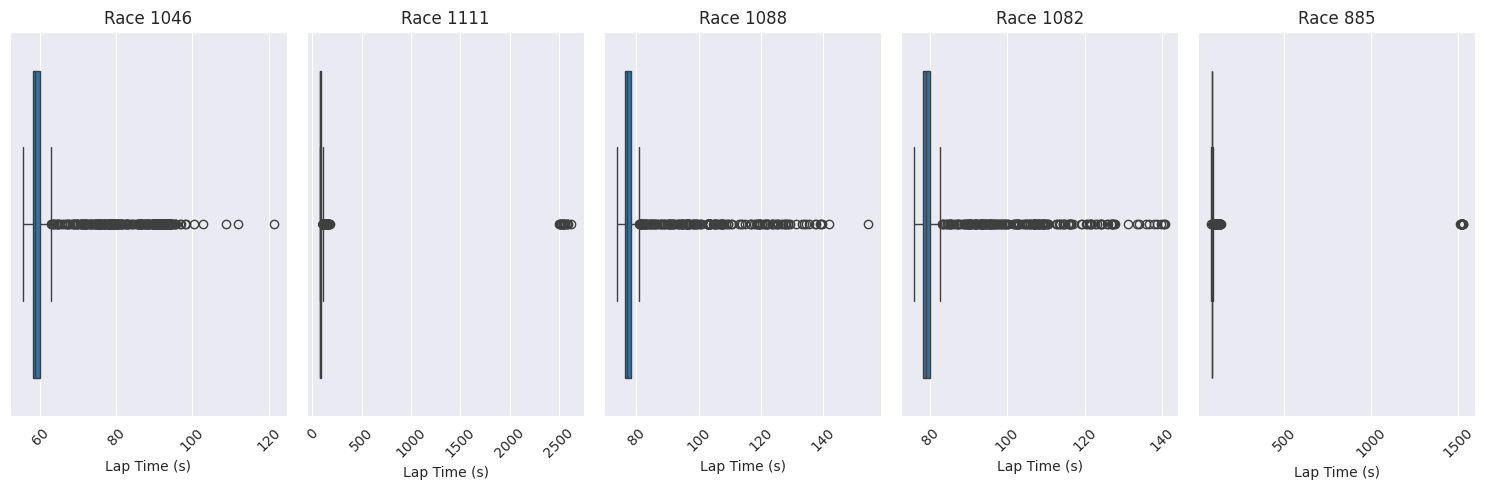

In [6]:
df["lap_time"] = df["lap_time"].astype(float)

top_races = df['raceId'].value_counts().index[:5]

plt.figure(figsize=(15, 5))
for i, race in enumerate(top_races, 1):
    plt.subplot(1, 5, i)
    sns.boxplot(x=df[df['raceId'] == race]['lap_time'])
    plt.title(f'Race {race}')
    plt.xticks(rotation=45)
    plt.xlabel('Lap Time (s)')
plt.tight_layout()
plt.show()

> We can see that when randomly plotting `lap_times`, a few values exceed 25 minutes, which is highly unlikely given the current race format. Therefore, we will impute these outliers using the median `lap_time`, grouped by `raceId` and `driverId`, and then recalculate the corresponding `total_time`.

In [7]:
def impute_race_outliers(df, iqr_multiplier=1.5):
    """
    Impute lap time outliers within each race using the driver's median lap time for that race.
    Also recalculates total_time for each driver based on corrected lap_times.
    """
    imputed_df = df.copy()
    race_stats = (
        imputed_df.groupby('raceId')['lap_time']
        .agg(['median', lambda x: x.quantile(0.25)])
        .rename(columns={'median': 'race_median', '<lambda_0>': 'q1'})
    )
    race_stats['q3'] = imputed_df.groupby('raceId')['lap_time'].quantile(0.75)
    race_stats['iqr'] = race_stats['q3'] - race_stats['q1']
    race_stats['lower_bound'] = race_stats['q1'] - iqr_multiplier * race_stats['iqr']
    race_stats['upper_bound'] = race_stats['q3'] + iqr_multiplier * race_stats['iqr']
    driver_medians = (
        imputed_df.groupby(['raceId', 'driverId'])['lap_time']
        .median()
        .reset_index()
        .rename(columns={'lap_time': 'driver_median'})
    )
    imputed_df = imputed_df.merge(
        race_stats[['lower_bound', 'upper_bound']],
        on='raceId', how='left'
    ).merge(
        driver_medians,
        on=['raceId', 'driverId'], how='left'
    )
    outlier_mask = (
        (imputed_df['lap_time'] < imputed_df['lower_bound']) |
        (imputed_df['lap_time'] > imputed_df['upper_bound'])
    )

    print(f"Imputing {outlier_mask.sum()} outlier laps "
          f"({outlier_mask.mean():.1%} of total)")

    imputed_df.loc[outlier_mask, 'lap_time'] = imputed_df.loc[outlier_mask, 'driver_median']
    imputed_df['total_time'] = (
        imputed_df.sort_values(['raceId', 'driverId', 'lap'])
        .groupby(['raceId', 'driverId'])['lap_time']
        .cumsum()
    )
    imputed_df.drop(columns=['lower_bound', 'upper_bound', 'driver_median'], inplace=True)

    return imputed_df
df1 = impute_race_outliers(df)

Imputing 20236 outlier laps (11.1% of total)


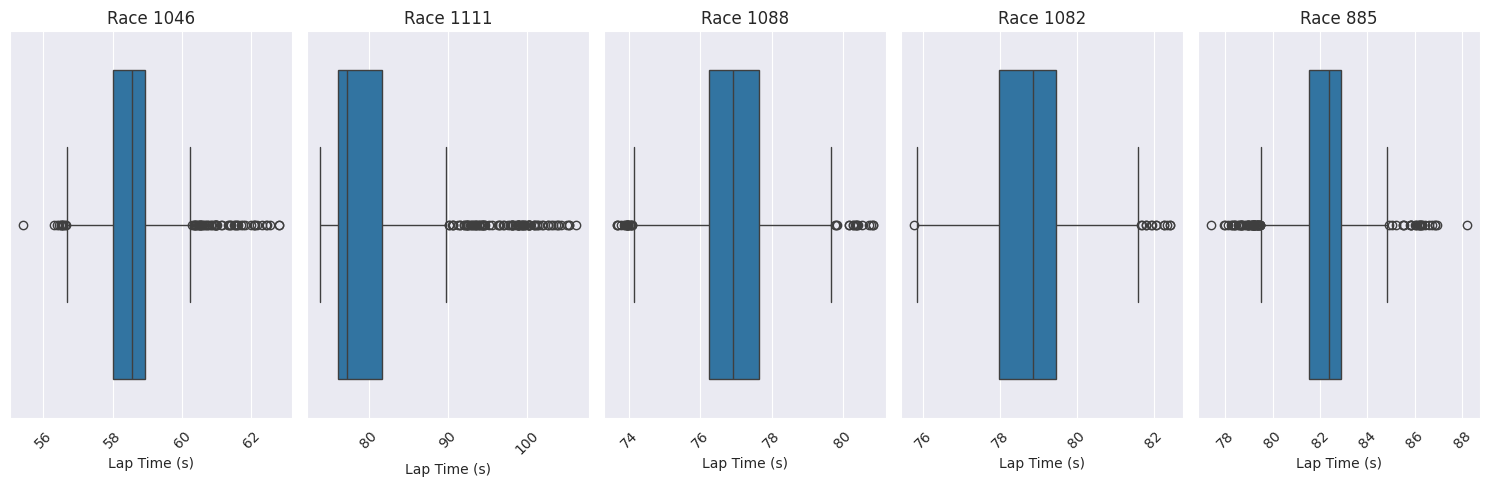

In [8]:
top_races = df1['raceId'].value_counts().index[:5]
plt.figure(figsize=(15, 5))
for i, race in enumerate(top_races, 1):
    plt.subplot(1, 5, i)
    sns.boxplot(x=df1[df1['raceId'] == race]['lap_time'])
    plt.title(f'Race {race}')
    plt.xticks(rotation=45)
    plt.xlabel('Lap Time (s)')
plt.tight_layout()
plt.show()

### Filling Missing `no_of_stops`
> To address missing values in `no_of_stops`, we first sort the dataset by `raceId`, `driverId`, and `lap`. We then incrementally fill the `no_of_stops` column based on whether a pit stop was taken on that lap, ensuring the count increases appropriately throughout the race for each driver.

In [9]:
def fill_number_of_stops(df):
    df = df.sort_values(by=['raceId', 'driverId', 'lap']).copy()
    def process_group(group):
        group = group.sort_values("lap").copy()
        no_of_stops = 0
        pit_stop_duration = 0.0
        for idx in group.index:
            val = group.at[idx, "no_of_stops"]
            duration = group.at[idx, "pit_stop_duration"]

            if pd.notna(val):
                no_of_stops = int(val)
                pit_stop_duration = float(duration)
            else:
                group.at[idx, "no_of_stops"] = no_of_stops
                group.at[idx, "pit_stop_duration"] = pit_stop_duration
        return group

    return df.groupby(['raceId', 'driverId'], group_keys=False).apply(process_group)
df1 = fill_number_of_stops(df1)


/tmp/ipykernel_1495/2079946479.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(['raceId', 'driverId'], group_keys=False).apply(process_group)


### Imputing `q1`, `q2`, `q3`
> We impute missing `q1` times using the mean `q1` for the corresponding race. If `q2` is missing, we fill it with the imputed `q1` value. For `q3`, we use the average of the imputed `q1` and `q2` times.

In [10]:
df1[['q1','q2','q3']] = df1[['q1','q2','q3']].replace('\\N', np.nan)
df1[['q1','q2','q3']] = df1[['q1','q2','q3']].astype(float)
df1['q1'] = df1['q1'].fillna(df1['q1'].mean())
df1['q2'] = df1['q2'].fillna(df1['q1'])
df1['q3'] = df1['q3'].fillna((df1['q1']+df1['q2'])/2)

/tmp/ipykernel_1495/4113606177.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1[['q1','q2','q3']] = df1[['q1','q2','q3']].replace('\\N', np.nan)


### Removing the races with empty `constructorId`

In [14]:
df1 = df1.replace('\\N', np.nan)
df1.dropna(inplace=True, axis=0)
df1.isnull().sum()

Unnamed: 0           0
raceId               0
driverId             0
lap                  0
lap_position         0
lap_time             0
constructorId        0
number               0
quali_position       0
q1                   0
q2                   0
q3                   0
no_of_stops          0
pit_stop_duration    0
result_position      0
total_laps           0
total_time           0
statusId             0
year                 0
round                0
grand_prix_name      0
driverRef            0
dtype: int64

## Distribution of `Total Time`

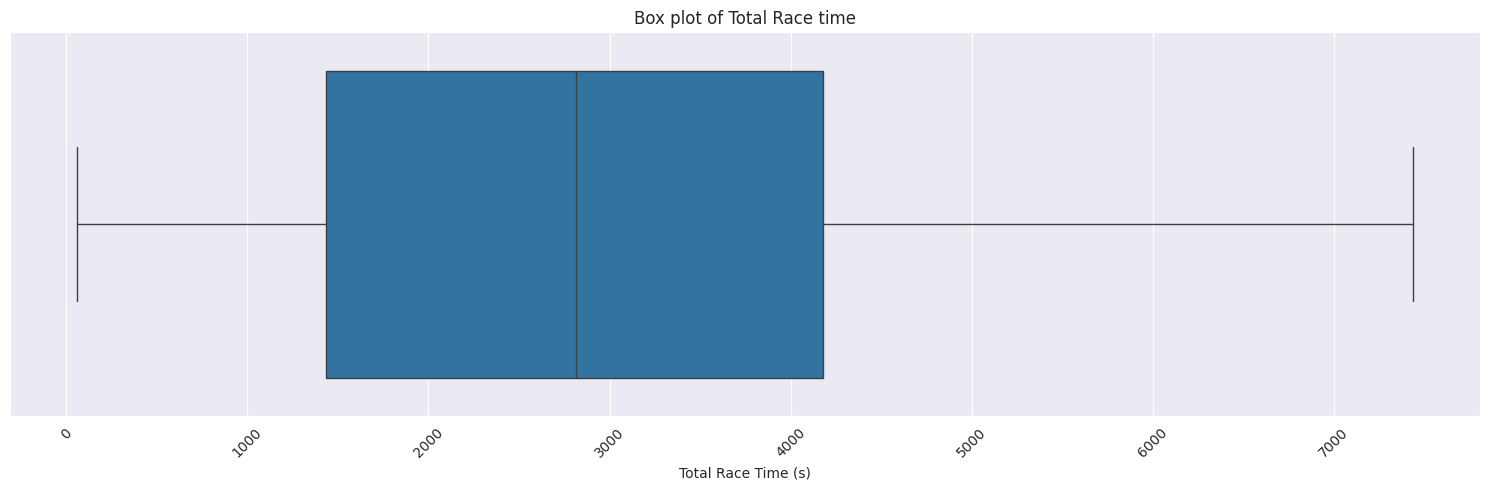

In [15]:
plt.figure(figsize=(15, 5))

sns.boxplot(x=df1["total_time"])
plt.title(f'Box plot of Total Race time')
plt.xticks(rotation=45)
plt.xlabel('Total Race Time (s)')
plt.tight_layout()
plt.show()

> After cleaning the dataset we can see that there are no outliers in `total_time`

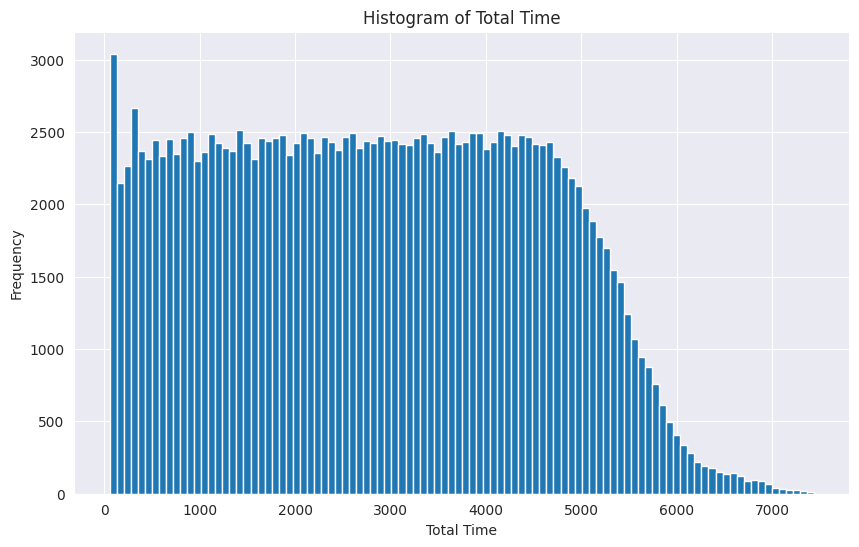

In [17]:
plt.figure(figsize=(10,6))
df1["total_time"].hist(bins=100)
plt.title("Histogram of Total Time")
plt.xlabel("Total Time")
plt.ylabel("Frequency")
plt.show()


> The distribution of `total_time` is nearly uniform, which is beneficial for model training as it avoids skewness. However, the drop in frequency beyond 5000 seconds could be attributed to races held in rainy conditions, which typically have longer completion times.

### Creating New Feature: `tyre_age`

In Formula 1 racing, knowing the tyre age at a given lap is extremely valuable. As observed in our exploratory data analysis (EDA), an increase in `tyre_age` significantly reduces the car’s speed, making it a crucial feature for performance prediction.

In [18]:
df2 = df1.sort_values(['raceId', 'driverId', 'lap']).copy()
df2['tyre_age'] = 0


for (race_id, driver_id), group in df2.groupby(['raceId', 'driverId']):
    tyre_age = 0
    last_stops = 0
    tyre_ages = []

    for _, row in group.iterrows():
        current_stops = row['no_of_stops']
        if current_stops > last_stops:
            tyre_age = 1  # New tyre
        else:
            tyre_age += 1
        tyre_ages.append(tyre_age)
        last_stops = current_stops
    df2.loc[group.index, 'tyre_age'] = tyre_ages


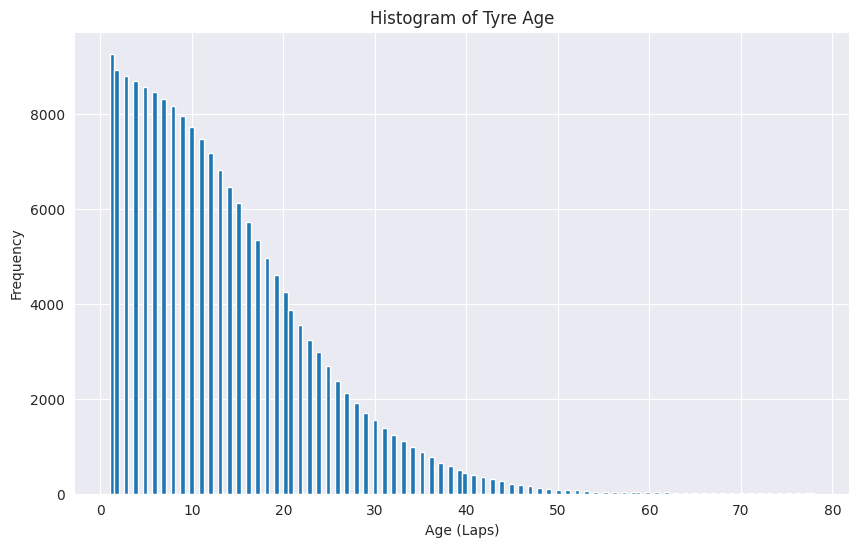

In [19]:
plt.figure(figsize=(10,6))
df2["tyre_age"].hist(bins=150)
plt.title("Histogram of Tyre Age")
plt.xlabel("Age (Laps)")
plt.ylabel("Frequency")
plt.show()

In [21]:
FEATURES = ['lap', 'lap_position', 'lap_time','quali_position', 'q1', 'q2', 'q3', 'total_laps',
       'no_of_stops', 'pit_stop_duration', 'tyre_age']
TARGET = ['total_time']

### Ordinary Least Squares (OLS)

The purpose of using Ordinary Least Squares (OLS) is to evaluate the significance of the initially selected features from our EDA in relation to the target variable. This helps us understand which features have the most impact on predicting the outcome.


In [22]:
X = df2[FEATURES].copy()
y = df2[TARGET].copy()
X = X.fillna(0)
y = y.fillna(0)
model_ols = sm.OLS(y, X).fit()
print(model_ols.summary())


                                 OLS Regression Results                                
Dep. Variable:             total_time   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          2.029e+06
Date:                Mon, 21 Apr 2025   Prob (F-statistic):                        0.00
Time:                        22:24:48   Log-Likelihood:                     -1.2871e+06
No. Observations:              181239   AIC:                                  2.574e+06
Df Residuals:                  181228   BIC:                                  2.574e+06
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

#### OLS Summary Interpretation

The **Ordinary Least Squares (OLS)** regression was used to understand the influence of various race features on the **`total_time`** a driver takes to finish the race.

- **R-squared (uncentered): 0.992**
  This indicates that **99.2%** of the variance in `total_time` is explained by the model's features, showing a very strong fit.

- **F-statistic: 2.03e+06 (p < 0.001)**
  This confirms the model is statistically significant overall.

- **Key Insights from Coefficients**:
  - **`lap` (90.60)**: As laps increase, total time increases substantially (as expected).
  - **`lap_position` (-4.43)**: Better lap position (i.e., leading) slightly reduces total time.
  - **`lap_time` (15.15)**: Longer lap times contribute significantly to higher total race time.
  - **`quali_position` (3.97)**: Poor qualifying position adds marginally to total time.
  - **`no_of_stops` (16.45)**: Each pit stop adds significant time.
  - **`tyre_age` (-0.89)**: Surprisingly shows a negative impact, possibly due to model multicollinearity or aggressive pit strategies.

- **Insignificant Predictors**:
  - **`pit_stop_duration` (p = 0.051)**: Barely significant, implying its standalone effect on `total_time` might be minimal.

- **Durbin-Watson: 0.143**
  Indicates **strong positive autocorrelation** in residuals — a common issue in time-series-like data (e.g., laps).

Overall, the model demonstrates a high explanatory power, validating the features chosen from EDA as meaningful predictors of total race time.

## Feature Scaling

In [23]:
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

feature_scaler.fit(df2[FEATURES])
target_scaler.fit(df2[TARGET])

save_path = 'scalers_prod'
os.makedirs(save_path, exist_ok=True)

joblib.dump(feature_scaler, f'{save_path}/feature_scaler.save')
joblib.dump(target_scaler, f'{save_path}/target_scaler.save')

feature_stats = pd.DataFrame({
    'feature': FEATURES,
    'mean': feature_scaler.mean_,
    'std': feature_scaler.scale_
})
feature_stats.to_csv(f'{save_path}/feature_stats.csv', index=False)

target_stats = pd.DataFrame({
    'target': TARGET,
    'mean': target_scaler.mean_,
    'std': target_scaler.scale_
})
target_stats.to_csv(f'{save_path}/target_stats.csv', index=False)

print("✅ Feature & target scalers and stats saved to:", save_path)
df1_scaled = df2.copy()
df1_scaled[FEATURES] = feature_scaler.transform(df1_scaled[FEATURES])
df1_scaled[TARGET] = target_scaler.transform(df1_scaled[TARGET])


✅ Feature & target scalers and stats saved to: scalers_prod


## Train, Validation, and Test Split
> The **test data** consists of a held-out set for races that took place in **2024**. This dataset allows us to evaluate how well the model performs on the most **recent and unseen race data**, providing a realistic measure of its generalization capabilities.


In [24]:
test_df = df1_scaled[df1_scaled["year"]==2024]
train_df = df1_scaled[df1_scaled["year"]!=2024]

In [25]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df[FEATURES], train_df[TARGET], test_size=0.2, random_state=42
)

In [26]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((131449, 11), (32863, 11), (131449, 1), (32863, 1))

In [27]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device).view(-1, 1)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device).view(-1, 1)
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)


Using device: cuda


### Model 1 : Deep Neural Network

In [28]:
class RegressionNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 37),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(37, 42),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(42, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.model(x)

model = RegressionNet(input_dim=X_train.shape[1]).to(device)


Epoch 001 | Train Loss: 0.0639 | Val Loss: 0.0118
Epoch 002 | Train Loss: 0.0211 | Val Loss: 0.0290
Epoch 003 | Train Loss: 0.0154 | Val Loss: 0.0284
Epoch 004 | Train Loss: 0.0129 | Val Loss: 0.0260
Epoch 005 | Train Loss: 0.0115 | Val Loss: 0.0243
Epoch 006 | Train Loss: 0.0106 | Val Loss: 0.0226
Epoch 007 | Train Loss: 0.0100 | Val Loss: 0.0230
Epoch 008 | Train Loss: 0.0096 | Val Loss: 0.0283
Epoch 009 | Train Loss: 0.0093 | Val Loss: 0.0305
Epoch 010 | Train Loss: 0.0091 | Val Loss: 0.0315
Epoch 011 | Train Loss: 0.0088 | Val Loss: 0.0289
Early stopping triggered.


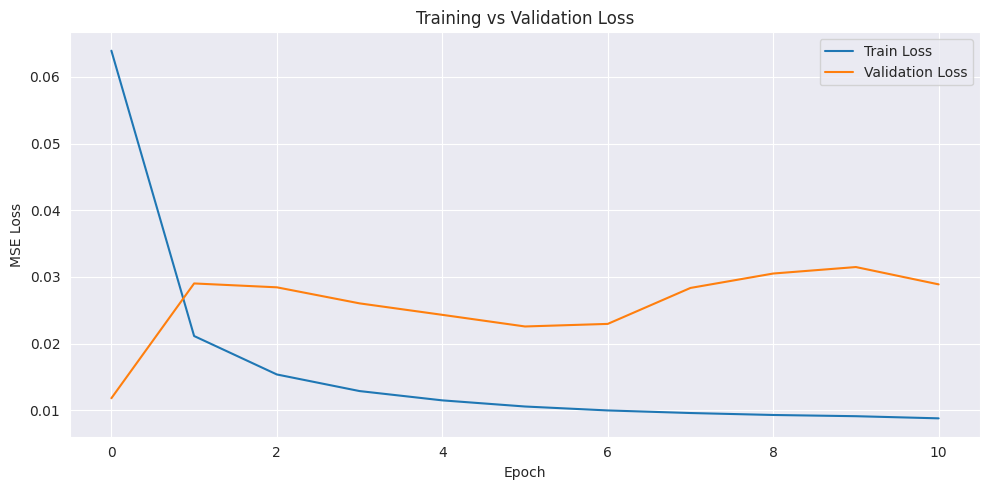

In [29]:

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 100
best_val_loss = float('inf')
early_stop_counter = 0

# Store losses for plotting
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(xb)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item() * len(xb)
    val_loss /= len(val_loader.dataset)

    # Store for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "regression_model.pt")
    else:
        early_stop_counter += 1
        if early_stop_counter >= 10:
            print("Early stopping triggered.")
            break

# --- 🔍 Plot loss curves ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
X_test = test_df[FEATURES]
y_test = test_df[TARGET]
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device).view(-1, 1)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load best model weights
model.load_state_dict(torch.load("regression_model.pt"))
model.eval()

# Make predictions
with torch.no_grad():
    preds = model(X_test_tensor).cpu().numpy()
    targets = y_test_tensor.cpu().numpy()

# Metrics
mse = mean_squared_error(targets, preds)
mae = mean_absolute_error(targets, preds)
r2 = r2_score(targets, preds)

print(f"📊 Test MSE: {mse:.4f}")
print(f"📊 Test MAE: {mae:.4f}")
print(f"📊 Test R² Score: {r2:.4f}")


📊 Test MSE: 0.0151
📊 Test MAE: 0.0815
📊 Test R² Score: 0.9836


### Model 1 Results:
Train Loss: 0.0088 | Val Loss: 0.0289 </br>
📊 Test MSE: 0.0151 </br>
📊 Test MAE: 0.0815 </br>
📊 Test R² Score: 0.9836 </br>

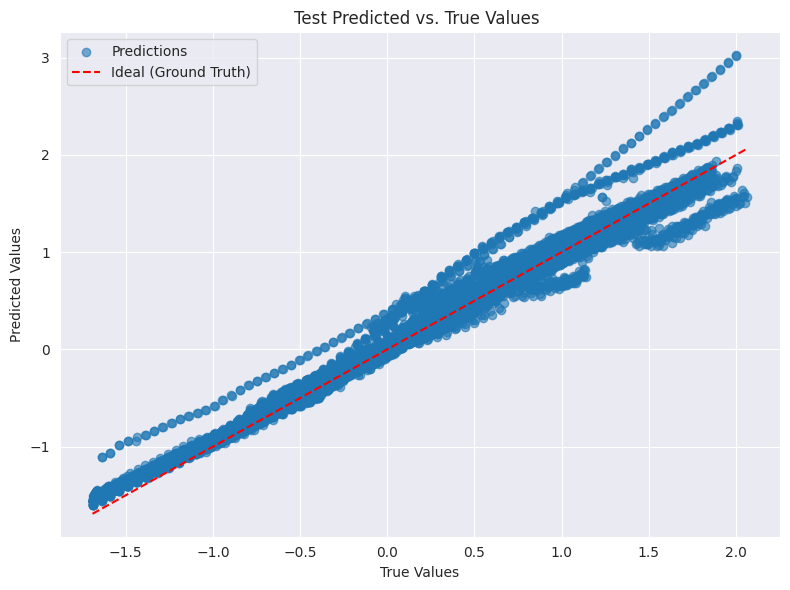

In [34]:
true_vals = y_test_tensor.cpu().numpy().flatten()
pred_vals = model(X_test_tensor).detach().cpu().numpy().flatten()

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_vals, pred_vals, alpha=0.6, label="Predictions")
plt.plot([true_vals.min(), true_vals.max()],
         [true_vals.min(), true_vals.max()],
         'r--', label="Ideal (Ground Truth)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Test Predicted vs. True Values ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

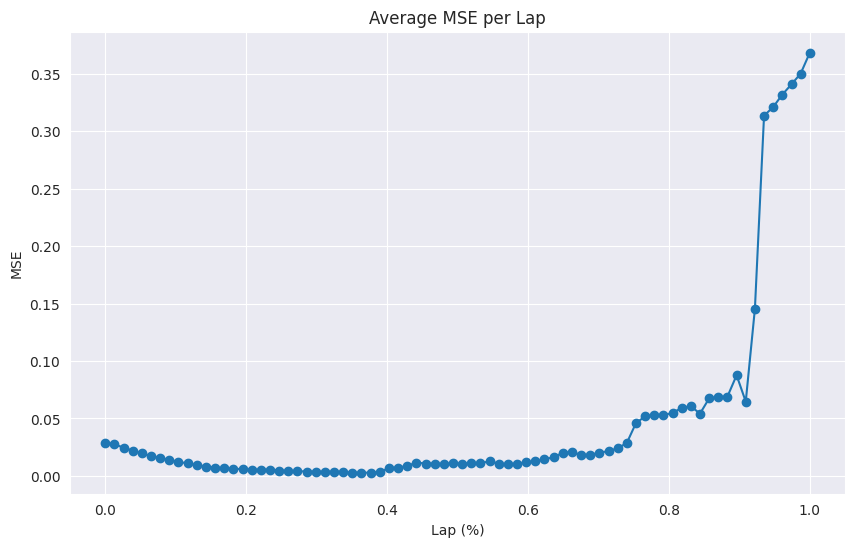

In [35]:
lap_list = sorted(test_df['lap'].unique())
lap_mse = []

for lap in lap_list:
    lap_df = test_df[test_df['lap'] == lap].copy()

    X_lap = lap_df[FEATURES].values.astype(np.float32)
    y_lap = lap_df[TARGET].values.astype(np.float32)
    X_tensor = torch.tensor(X_lap, dtype=torch.float32).to(device)
    y_true = y_lap

    with torch.no_grad():
        y_pred = model(X_tensor).cpu().numpy()

    mse = mean_squared_error(y_true, y_pred)
    lap_mse.append(mse)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, 1, len(lap_mse)), lap_mse, marker='o')
plt.title("Average MSE per Lap")
plt.xlabel("Lap (%)")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

### Progress of Laps vs Prediction MSE
> We observe that the **MSE is high during the initial laps**, gradually **decreases in the mid-phase**, and then **increases significantly toward the final laps**. This pattern deserves further investigation. The sharp rise in error during the final stages could be due to the **strong correlation between ending laps and race outcomes**, making predictions more sensitive and harder to model accurately.

## Model 2: LSTM + DNN
> The purpose of this model is to feed in the **previous N lap times** (in our case, 5 laps) to capture a driver's temporal race behavior. This historical information allows the model to **learn driving patterns** and better predict the final `total_time` required to complete the race, with the goal of reducing the **Mean Squared Error (MSE)**.

### Model Architecture
- **Input 1 (Sequential):** The previous 5 `lap_times` are fed into an **LSTM** layer. This allows the model to capture temporal dependencies and pacing trends across laps.
- **LSTM Output:** The LSTM outputs a **2-dimensional hidden representation** summarizing the sequence.
- **Input 2 (Static):** A set of race-specific and driver-specific static features such as `lap`, `quali_position`, `pit_stop_duration`, `no_of_stops`, `total_laps`, `tyre_age`, etc.
- **Concatenation:** The LSTM output and the static features are concatenated to form a single feature vector.
- **DNN Head:** The concatenated vector is passed through a **fully connected neural network** (DNN) with a few hidden layers to regress and predict the `total_time`.


In [36]:
FEATURES = ['lap', 'lap_position', 'quali_position', 'q1', 'q2', 'q3', 'no_of_stops', 'pit_stop_duration', 'total_laps', 'tyre_age','lap_time']
TARGET = ['total_time']
# === 1. Fit scalers ===
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Fit on data
feature_scaler.fit(df2[FEATURES])
target_scaler.fit(df2[TARGET])

# === 2. Save scalers ===
save_path = 'scalers_prod'
os.makedirs(save_path, exist_ok=True)

joblib.dump(feature_scaler, f'{save_path}/feature_scaler_2.save')
joblib.dump(target_scaler, f'{save_path}/target_scaler_2.save')

# === 3. Save stats for reference ===
feature_stats = pd.DataFrame({
    'feature': FEATURES,
    'mean': feature_scaler.mean_,
    'std': feature_scaler.scale_
})
feature_stats.to_csv(f'{save_path}/feature_stats.csv', index=False)

target_stats = pd.DataFrame({
    'target': TARGET,
    'mean': target_scaler.mean_,
    'std': target_scaler.scale_
})
target_stats.to_csv(f'{save_path}/target_stats.csv', index=False)

print("✅ Feature & target scalers and stats saved to:", save_path)
df2_scaled = df2.copy()
df2_scaled[FEATURES] = feature_scaler.transform(df2_scaled[FEATURES])
df2_scaled[TARGET] = target_scaler.transform(df2_scaled[TARGET])

✅ Feature & target scalers and stats saved to: scalers_prod


### Data Loader

In [37]:
class RaceDataset(Dataset):
    def __init__(self, df, sequence_length=10):
        self.seq_len = sequence_length
        self.samples = []

        grouped = df.groupby(['raceId', 'driverId'])
        for (race_id, driver_id), group in grouped:
            group = group.sort_values('lap')
            if len(group) >= sequence_length:
                for i in range(sequence_length, len(group)):
                    lap_sequence = group.iloc[i-sequence_length:i]['lap_time'].values.astype(np.float32)
                    static_features = group.iloc[i][[
                        'lap', 'lap_position', 'quali_position',
                        'q1', 'q2', 'q3', 'no_of_stops', 'pit_stop_duration',
                        'total_laps', 'tyre_age'
                    ]].values.astype(np.float32)
                    total_time = group.iloc[i]['total_time']
                    self.samples.append((lap_sequence, static_features, total_time))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        lap_seq, static_feat, target = self.samples[idx]
        return torch.tensor(lap_seq), torch.tensor(static_feat), torch.tensor(target, dtype=torch.float32)


### Model Definition

In [38]:
class LSTMWithStatic(nn.Module):
    def __init__(self, lstm_input=1, lstm_hidden=32, static_input=10):
        super().__init__()
        self.lstm = nn.LSTM(input_size=lstm_input, hidden_size=lstm_hidden, batch_first=True)
        self.fc_lstm = nn.Linear(lstm_hidden, 2)
        self.fc_final = nn.Sequential(
            nn.Linear(2 + static_input, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, seq_input, static_input):
        seq_input = seq_input.unsqueeze(-1)  # (B, T) -> (B, T, 1)
        _, (h_n, _) = self.lstm(seq_input)
        lstm_out = self.fc_lstm(h_n[-1])  # (B, 2)
        combined = torch.cat([lstm_out, static_input], dim=1)
        return self.fc_final(combined).squeeze(1)


In [39]:
def train_model(df, model_save_path="best_lstm_model.pt", patience=10, max_epochs=100):
    dataset = RaceDataset(df)
    train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=64)

    model = LSTMWithStatic()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    early_stop_counter = 0

    for epoch in range(1, max_epochs + 1):
        model.train()
        train_loss = 0
        for seq, stat, target in train_loader:
            optimizer.zero_grad()
            pred = model(seq, stat)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(seq)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for seq, stat, target in val_loader:
                pred = model(seq, stat)
                loss = criterion(pred, target)
                val_loss += loss.item() * len(seq)
                all_preds.append(pred)
                all_targets.append(target)
        val_loss /= len(val_loader.dataset)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # --- Save Best Model ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print("✅ Saved best model!")
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("⏹️ Early stopping triggered.")
                break

    # Final Evaluation
    model.load_state_dict(torch.load(model_save_path))  # Load best model
    model.eval()
    with torch.no_grad():
        all_preds = torch.cat(all_preds).numpy()
        all_targets = torch.cat(all_targets).numpy()
    print(f"\nFinal R² Score: {r2_score(all_targets, all_preds):.4f}")
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    print(f"Final RMSE: {rmse:.4f}")

    # 📈 Plot Losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Model Training

Epoch 001 | Train Loss: 0.0215 | Val Loss: 0.0038
✅ Saved best model!
Epoch 002 | Train Loss: 0.0029 | Val Loss: 0.0029
✅ Saved best model!
Epoch 003 | Train Loss: 0.0025 | Val Loss: 0.0022
✅ Saved best model!
Epoch 004 | Train Loss: 0.0023 | Val Loss: 0.0020
✅ Saved best model!
Epoch 005 | Train Loss: 0.0022 | Val Loss: 0.0020
Epoch 006 | Train Loss: 0.0020 | Val Loss: 0.0017
✅ Saved best model!
Epoch 007 | Train Loss: 0.0020 | Val Loss: 0.0018
Epoch 008 | Train Loss: 0.0020 | Val Loss: 0.0016
✅ Saved best model!
Epoch 009 | Train Loss: 0.0017 | Val Loss: 0.0016
✅ Saved best model!
Epoch 010 | Train Loss: 0.0018 | Val Loss: 0.0016
Epoch 011 | Train Loss: 0.0017 | Val Loss: 0.0017
Epoch 012 | Train Loss: 0.0016 | Val Loss: 0.0016
Epoch 013 | Train Loss: 0.0016 | Val Loss: 0.0014
✅ Saved best model!
Epoch 014 | Train Loss: 0.0015 | Val Loss: 0.0014
Epoch 015 | Train Loss: 0.0015 | Val Loss: 0.0014
Epoch 016 | Train Loss: 0.0014 | Val Loss: 0.0014
Epoch 017 | Train Loss: 0.0014 | Val Los

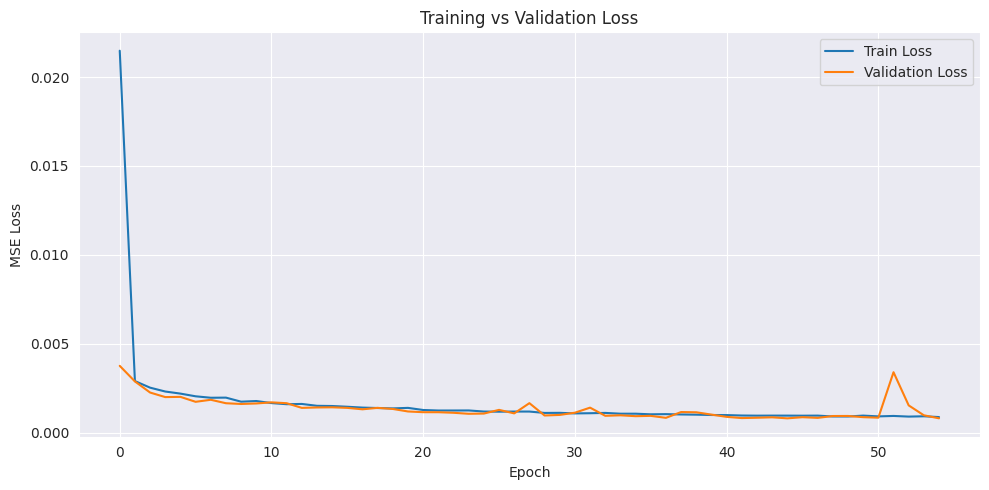

In [40]:
train_model(df2_scaled.copy())

### Model testing on 2024 races

In [41]:
test_df = df2[df2["year"] == 2024]
test_df_scaled = test_df.copy()
test_df_scaled[FEATURES] = feature_scaler.transform(test_df_scaled[FEATURES])
test_df_scaled[TARGET] = target_scaler.transform(test_df_scaled[TARGET])


📌 Test Metrics:
✅ MSE      : 0.0008
✅ MAE      : 0.0158
✅ RMSE     : 0.0286
✅ R² Score : 0.9987


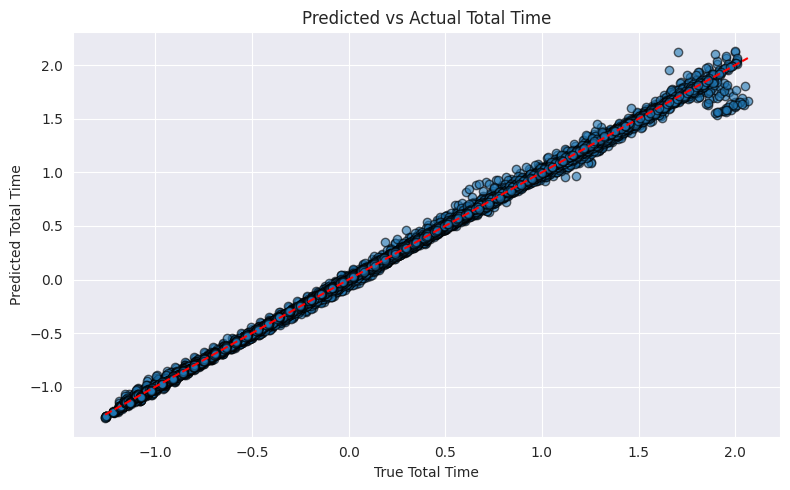

In [42]:
def test_model(test_df, model_path="best_lstm_model.pt"):
    import torch
    from torch.utils.data import DataLoader
    import matplotlib.pyplot as plt
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

    # Dataset and loader
    test_dataset = RaceDataset(test_df)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Load model
    model = LSTMWithStatic()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Inference
    all_preds, all_targets = [], []
    with torch.no_grad():
        for seq, stat, target in test_loader:
            pred = model(seq, stat)
            all_preds.append(pred)
            all_targets.append(target)

    # Concatenate
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    # 📊 Metrics
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    # rmse = mean_squared_error(all_targets, all_preds, squared=False)
    r2 = r2_score(all_targets, all_preds)

    print("\n📌 Test Metrics:")
    print(f"✅ MSE      : {mse:.4f}")
    print(f"✅ MAE      : {mae:.4f}")
    print(f"✅ RMSE     : {rmse:.4f}")
    print(f"✅ R² Score : {r2:.4f}")

    # 📈 Plot Predictions vs Ground Truth
    plt.figure(figsize=(8, 5))
    plt.scatter(all_targets, all_preds, alpha=0.6, edgecolor='k')
    plt.plot([all_targets.min(), all_targets.max()],
             [all_targets.min(), all_targets.max()], 'r--')
    plt.xlabel("True Total Time")
    plt.ylabel("Predicted Total Time")
    plt.title("Predicted vs Actual Total Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
test_model(test_df_scaled)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


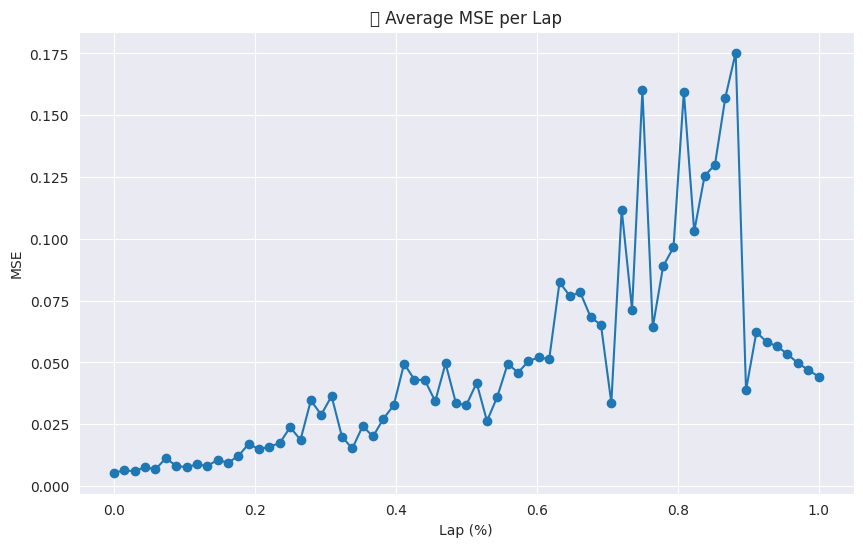

In [49]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import torch

lap_list = sorted(test_df_scaled['lap'].unique())
lap_mse = []

model = LSTMWithStatic()
model.load_state_dict(torch.load("best_lstm_model.pt"))
model.eval()

for lap in lap_list:
    lap_df = test_df_scaled[test_df_scaled['lap'] == lap].copy()
    total_laps = test_df_scaled[test_df_scaled['lap'] == lap]["total_laps"]
    if lap < -1.146307:
        continue
    seq_inputs = []
    static_inputs = []
    targets = []
    for driver_id in lap_df['driverId'].unique():
        driver_laps = test_df_scaled[(test_df_scaled['driverId'] == driver_id) & (test_df_scaled['lap'] <= lap)]
        if len(driver_laps) < 5:
            continue
        driver_laps = driver_laps.sort_values('lap').iloc[-5:]

        seq = driver_laps['lap_time'].values.astype(np.float32)
        static = driver_laps.iloc[-1][[
                        'lap', 'lap_position', 'quali_position',
                        'q1', 'q2', 'q3', 'no_of_stops', 'pit_stop_duration',
                        'total_laps', 'tyre_age'
                    ]].values.astype(np.float32)
        target = driver_laps.iloc[-1]['total_time']

        seq_inputs.append(seq)
        static_inputs.append(static)
        targets.append(target)

    if len(seq_inputs) == 0:
        continue

    seq_tensor = torch.tensor(seq_inputs)
    static_tensor = torch.tensor(static_inputs)
    target_tensor = torch.tensor(targets)

    with torch.no_grad():
        preds = model(seq_tensor, static_tensor).squeeze().numpy()

    mse = mean_squared_error(targets, preds)
    lap_mse.append((lap/total_laps, mse))

laps_percent = np.linspace(0, 1, len(lap_mse))
mse_vals = [m[1] for m in lap_mse]

plt.figure(figsize=(10, 6))
plt.plot(laps_percent, mse_vals, marker='o')
plt.title("📊 Average MSE per Lap")
plt.xlabel("Lap (%)")
plt.ylabel("MSE")
plt.grid(True)
plt.show()


## 📌 Verdict: Model Comparison

We compared two models—**Model 1 (Baseline DNN)** and **Model 2 (LSTM + DNN)**—for the task of predicting a driver's `total_time` using both static and sequential race features.

### 🔍 Summary of Results

| Metric         | Model 1 (Baseline DNN) | Model 2 (LSTM + DNN) |
|----------------|-------------------------|------------------------|
| **Train Loss** | 0.0088                  | 0.0009                 |
| **Val Loss**   | 0.0289                  | 0.0008                 |
| **Test MSE**   | 0.0151                  | ✅ **0.0008**          |
| **Test MAE**   | 0.0815                  | ✅ **0.0158**          |
| **Test RMSE**  | 0.1229                  | ✅ **0.0286**          |
| **Test R²**    | 0.9836                  | ✅ **0.9987**          |
| **Early Stopping** | ❌ Not Triggered    | ✅ Triggered @Epoch 55 |

---

### 📈 True vs Predicted Curve Insights

| Observation Type                | Model 1                                  | Model 2                                |
|---------------------------------|------------------------------------------|----------------------------------------|
| **Overall Trend Fit**           | Captures general pattern                 | Excellent alignment with true values   |
| **Error Distribution**          | Larger residuals across entire curve     | Small residuals, especially mid-range  |
| **Deviation at Edges**          | Deviates throughout                     | Slight deviation at top-right (high values) |
| **Predicted Points**            | Loosely scattered around the red line    | Tightly packed around the red line     |

---

### 🧠 Interpretation

- **Model 1** does reasonably well overall, but its predictions show **more variance** and **larger errors**, especially in races with extreme conditions or lap anomalies.
- **Model 2** significantly outperforms the baseline by leveraging **historical lap patterns** via LSTM. Its predictions are much **closer to actual values**, with tighter spread and better generalization.

---

### ✅ Verdict

> **Model 2 (LSTM + DNN)** is clearly the superior model in terms of both **prediction accuracy** and **consistency**.
It is recommended for deployment and further enhancement for real-time race prediction or race simulation use cases.